참고문헌

- 파이썬 딥러닝 파이토치 (이경택, 방심수, 안상준 지음), 정보문화사

- https://gaussian37.github.io/dl-pytorch-snippets/

- 2023 KAIA 한국인공지능학회 / Introduction to pytorch (Hyunchul Kim) / 링크 : https://www.youtube.com/watch?v=YX-AgT-Kovg

- PyTorch로 시작하는 딥 러닝 입문 (유원준, 안상준 지음), 링크 : https://wikidocs.net/book/2788

# 6. Convolutional Neural network (CNN)


## 4. CNN : CIFAR10 데이터 적용

- CIFAR-10 데이터셋 : 딥러닝 실험용으로 쓸수 있는 컬러 이미지 데이터 중 하나.
  + 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭의 10개의 클래스로 구성.
  + 각 클래스당 5000장의 이미지인 train dataset과 1000장의 이미지인 test dataset으로 구성

  <img src='https://drive.google.com/uc?export=download&id=1prxxdDh70mioLxCfSCRhKFuf1R8CjcIp' width="600" height ="" /><br>

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


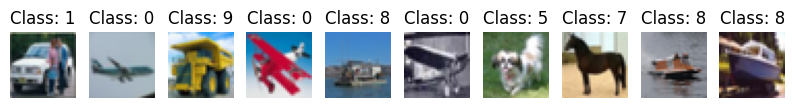

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [9]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):

        # data
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        # cost function
        output = model(image)
        loss = criterion(output, label)

        # gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 결과 출력
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
''' 10. CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

<ipython-input-8-85e6e3205f6e>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.331136
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.729396
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.849681
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.529818
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.647498
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.650491
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.751321
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.414683

[EPOCH: 1], 	Test Loss: 1.6179, 	Test Accuracy: 41.66 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.513370
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.491950
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.615988
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.657137
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.209043
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.457688
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.301793
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.494028

[EPOCH: 2], 	Test Loss: 1.3599, 	Test Accuracy: 50.34 % 

- 성능은 약 65%

__코드 설명__

<img src='https://drive.google.com/uc?export=download&id=1LrwzbvRB5g8bUlNselYZUUiHrwC5xi2r' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1D8UqLhQVVTMSDJRf6ZLKOm2EgiXAUj4N' width="500" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1FV5B-s7wyA2srZjNCou9cJA073knNot8' width="" height ="" /><br>

## 5. MLP : CIFAR10 데이터 적용 및 CNN과의 비교

- 이미지 데이터에 특화된 CNN이 아닌 MLP를 활용할 경우 어떻게 되는지 확인해보자.

In [13]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [14]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [15]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [16]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


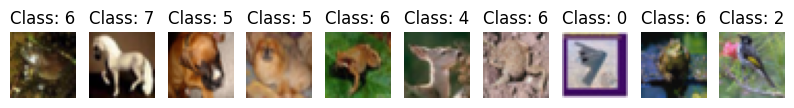

In [17]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [18]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        #x = F.log_softmax(x, dim = 1)
        return x

In [19]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [20]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [21]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [22]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.301148
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.923228
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.776949
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.918990
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.978751
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.835931
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.624014
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.687343

[EPOCH: 1], 	Test Loss: 1.6820, 	Test Accuracy: 39.95 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.574552
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.807253
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.421819
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.858582
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.743791
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.678833
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.782046
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.600030

[EPOCH: 2], 	Test Loss: 1.6026, 	Test Accuracy: 42.65 % 

- 성능은 48%로 CNN을 활용한 것이 확실히 우위를 보임

__코드 설명__

<img src='https://drive.google.com/uc?export=download&id=1CBkDTf11fGK7oIsf34GAXiKkS_1hc6V5' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1HHmVYQKRW1XGLK-Rh972EyLtOg-QR3yd' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1brDdXiTfSKI6wosbpgWOpvqu9L1wZ1eC' width="510" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1LJJFTFKa_nZqoeBznwT-6CnDAHegV9ni' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1N-KM3j9xVR2BBl0GoIKV1o9StrOH5UOx' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1cx5ZDQoWU7z0fciw1o-AjZ4u8bDWOa42' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1FGv7LSLh54MJkzAnlEHGUzabzsujAc5N' width="" height ="" /><br>

## 6. CNN with augmentation : CIFAR10 데이터 적용

-

In [28]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [29]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [30]:
BATCH_SIZE = 32
EPOCHS = 10

In [31]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


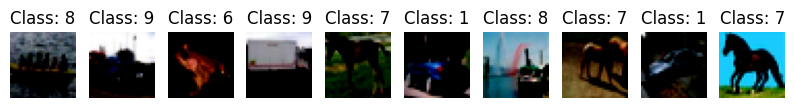

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
''' 6. Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [ ]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 10. CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

<ipython-input-31-c30d01112e31>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.292583
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.200186
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.975636
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.412444
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.819656
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.756250
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.827639
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.548152

[EPOCH: 1], 	Test Loss: 1.3828, 	Test Accuracy: 50.05 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.449858
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.339325
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.617493
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.718443
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.657080
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.247609
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.336477
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.651940

[EPOCH: 2], 	Test Loss: 1.2396, 	Test Accuracy: 55.81 % 

__코드 설명__

<img src='https://drive.google.com/uc?export=download&id=1ugFPAPzlg8ebOvommj-1ZcgWLSbAJ5Ww' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1C4cgNDv-lvaRTRsImkNwk_T8UG2mOcRU' width="500" height ="" /><br>

## 7. ResNet : CIFAR10 데이터 적용

In [32]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [33]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [34]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:06<00:00, 27851045.56it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


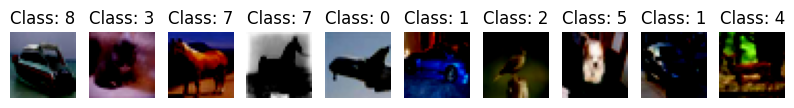

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [35]:
''' 6. ResNet 모델 설계하기 '''
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [36]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [37]:
''' 8. ResNet 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [38]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [39]:
''' 10. ResNet 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.452757
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.681602
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.506402
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.425130
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.239313
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.337432
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.007596
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.281742

[EPOCH: 1], 	Test Loss: 1.1087, 	Test Accuracy: 59.91 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.311001
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.172565
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.834807
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.887535
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.022058
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.870357
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.717144
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.497401

[EPOCH: 2], 	Test Loss: 1.0809, 	Test Accuracy: 62.54 % 

__코드 설명__


<img src='https://drive.google.com/uc?export=download&id=1fUNu8xnuxAOc9kLVZO3jtyvYZFEs7hDa' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=19Cjurt2OBIfrHzxn-qOYhvbbJyd8tr9D' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1JXwq_vsBXz12WXjf1FnjIy8cpy1rTcIf' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1u1hR8u-K-andDMxKb9qT5Vi3A7RfqMl0' width="" height ="" /><br>


## 8. 대표적인 딥러닝 모델을 불러와 적용해보기

In [40]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [41]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.5.1+cu121  Device: cuda


In [42]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12427996.33it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


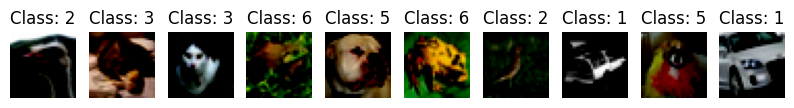

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [45]:
''' 6. PyTorch 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
# num_ftrs
# 512 -> 1000
# 512 -> 10
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

In [46]:
''' 7. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
''' 8. 불러온 Resnet34 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [48]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 10. 불러온 ResNet34 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.661670
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.771076
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.660440
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.379975
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.627959
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.608934
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.326402
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.941766

[EPOCH: 1], 	Test Loss: 1.2788, 	Test Accuracy: 56.86 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.626966
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.021273
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.614906
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.345936
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.803245
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.184109
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.214387
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.247316

[EPOCH: 2], 	Test Loss: 0.9906, 	Test Accuracy: 64.69 % 

KeyboardInterrupt: 

__코드 설명__


<img src='https://drive.google.com/uc?export=download&id=1i4JJuLXQerGVCqQkS54VqPQJ3Kd4NF4t' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1-7iidtcmdocZ5H28sbIDNm09sWzcro6X' width="" height ="" /><br>


## 9. Transfer learning

In [ ]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
# colab과 google 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
# https://www.kaggle.com/datasets/ajayrana/hymenoptera-data?resource=download
image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/(Lecture) Machine Learning/data/hymenoptera_data/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


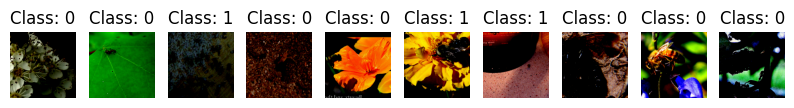

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.808103
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.692242
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.693007

[EPOCH: 1], 	Test Loss: 0.7207, 	Test Accuracy: 54.91 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.649223
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.695978
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.649946

[EPOCH: 2], 	Test Loss: 0.7289, 	Test Accuracy: 56.93 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.660005
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.627717
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.703617

[EPOCH: 3], 	Test Loss: 0.6901, 	Test Accuracy: 61.71 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.755395
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.630194
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.737861

[EPOCH: 4], 	Test Loss: 0.6746, 	Test Accuracy: 64.74 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.561629
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.669185
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.695428

In [ ]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.858841
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.910176
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.798357

[EPOCH: 1], 	Test Loss: 0.6528, 	Test Accuracy: 65.24 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.615203
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.662059


KeyboardInterrupt: 

__코드 설명__

<img src='https://drive.google.com/uc?export=download&id=19zhgIptLl4-jdcJUybMPqp6QrEsSu2Lt' width="420" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1RanM841lC86GttIC-oKw3dH7xJOhe4D2' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1uQaM6zXMhwQLZPj5Dx6Fy7Bio8_s7BNN' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1cgIbyINaeLMaweqf6H2R2v8UjjRTfjd-' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1cgIbyINaeLMaweqf6H2R2v8UjjRTfjd-' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1KqJqilzGTYai48mi_UEuRXisyC37H8dO' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=1XS2z9oNn2Ptg5AGWaynDYTHqx33ui5a1' width="" height ="" /><br>

<img src='https://drive.google.com/uc?export=download&id=18DmoU0crolYYwdwQeweJgcBEb9Q8WFsW' width="420" height ="" /><br>